In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import os
import matplotlib.pylab as plt
import scipy
import seaborn as sns

# loading time series data

url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv',error_bad_lines=False)  #( time_series_19-covid-Confirmed.csv)
df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)

#df = pd.read_csv(url, error_bad_lines=False)
date='4/7/20'
odir = 'seiirr_v3_'+date.replace('/','_') + '/'
try:  
    os.mkdir(odir)  
except OSError as error:  
    print('Directory exists: ', odir)

df_confirmed=df_confirmed.groupby(['Country']).sum()
df_confirmed=df_confirmed.drop(columns=['Lat','Long'])
top_affected_countries=df_confirmed.sort_values([date],ascending=False).index[:40].values #20/20

df=df_confirmed.loc[top_affected_countries,:]



#df= pd.read_csv("confirmed-data-top-affected-countries.csv")

'''
import os
date='3/29/20'
odir = date.replace('/','_') + '/'

df= pd.read_csv("../countries-spread-rate/"+odir+"confirmed-data-top-affected-countries.csv")
try:  
    os.mkdir(odir)  
except OSError as error:  
    print(error)
'''    

print('countries to choose from: ', df.index)

# loading population data
df_pop=pd.read_csv("population_by_country_2020.csv")




Directory exists:  seiirr_v3_4_7_20/
countries to choose from:  Index(['US', 'Spain', 'Italy', 'Germany', 'China', 'France', 'Iran',
       'United Kingdom', 'Turkey', 'Switzerland', 'Belgium', 'Netherlands',
       'Canada', 'Brazil', 'Austria', 'Portugal', 'Korea, South', 'Israel',
       'Sweden', 'Russia', 'Norway', 'Australia', 'Ireland', 'India',
       'Denmark', 'Chile', 'Czechia', 'Poland', 'Romania', 'Pakistan',
       'Malaysia', 'Japan', 'Philippines', 'Ecuador', 'Luxembourg', 'Peru',
       'Saudi Arabia', 'Mexico', 'Indonesia', 'Serbia'],
      dtype='object', name='Country')


In [11]:
start_from=np.where(df.columns == '2/15/20')[0][0]
df=df[df.columns[start_from:]]

In [12]:
# plot settings
from matplotlib import rc
#matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=16)  # 24
rc("axes", linewidth=0.5)  # 2)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('legend', fontsize=10)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)

In [13]:
# get time v/s confirmed cases(10-500) and Ti data for a particular country

def get_data(country,l=None):
    #ydata= df[df["Country"]==country].values[0,1:]
    ydata=df.loc[country].values
    ydata = np.array(ydata, dtype=float)
    idx=np.where(ydata>=50)[0][0]
    idx2= np.where(ydata>1)[0][0]
    #ydata=ydata[idx2:]
    
    #idx1= np.where(ydata>=1000)[0][0]
    #ydata=ydata[:idx1]
    
    if l!=None:
        ydata = ydata[:l]
    max_days=len(ydata)
    xdata= np.arange(max_days)
    return xdata,ydata, idx


In [14]:
# SEIIRR Model Parameter Estimation
def seiirr_ivp(x,y,p,beta,Td,Tr,Tl):
    S,E,Iu,Id,Rd,Ru = y
    sigma = 1/Tl
    Sd = -beta * (Id + Iu) * S
    Ed = beta * (Id + Iu) * S - sigma * E
    Iud = (1-p) * sigma * E - Iu/Tr
    Idd = p * sigma * E - Id/Td
    Rdd = Id/Td
    Rud = Iu/Tr
    return Sd, Ed, Iud, Idd, Rdd, Rud

def eval_model_seiirr(params,xdata,ydata,min_routine=True): # params: parameters to optimize over: p, beta, Ti

    p,beta,Ti = params
    
    max_days=np.max(xdata)+1

    Rd0 = ydata[0]
    E0 = (Rd0 * (Ti + Td) * Tl) / (p * Ti**2)
    Id0 = Rd0 * Td / Ti
    Iu0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr) * Tr/Tl
    Ru0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr)
    S0 = 1 - (Rd0 + E0 + Id0 + Iu0 + Ru0 )
    
    
    if min_routine == True:
        sol = integrate.solve_ivp(seiirr_ivp, [0, max_days], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,beta,Td,Tr,Tl),t_eval=np.arange(max_days),method='RK45')
        #optim_days = min(100, max_days)  # Days to optimise for
        #weights = 1 / np.arange(1, optim_days+1)[::-1]  
        msle_cases = mean_squared_log_error(ydata, (sol.y[4,xdata.astype(int)])) 
        return msle_cases
    else:
        max_days=100
        sol = integrate.solve_ivp(seiirr_ivp, [0, max_days], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,beta,Td,Tr,Tl),t_eval=np.arange(max_days),method='RK45')
        return sol
    
import itertools
marker = itertools.cycle(( '*', 'o', '*')) 
no_bounds=((0.01,1),(0.,10.))
def fit_seiirr(xdata,ydata,bounds=no_bounds,l=14):

    
    #print(Ti)
    res_const = minimize(eval_model_seiirr,([.1, 1.,5]), bounds=bounds,args=(xdata,ydata),method='L-BFGS-B') ## numbers are initial guess
    l=None
    msle_cases=eval_model_seiirr(res_const.x,xdata,ydata)
    plt.figure(figsize=(10,7))
    p,beta,Ti1=res_const.x
    sigma= 1./Tl
    gammaD = 1./Td
    gammaR= 1./Tr
    coeff=[1,(gammaD + gammaR + sigma), gammaD*gammaR + sigma*(gammaD+gammaR-beta), p*beta*sigma*(gammaD-gammaR) + sigma*gammaD*(gammaR-beta) ]
    coeff=np.array(coeff)
    lambdas=np.roots(coeff)
   # lambdas=lambdas[lambdas>0]
    R0 = beta*(p* Td + (1-p)*Tr)
    R0obs = beta*p*Td
    la =  ": p = %.4f, "%p +r" $\beta$ =  %3.2f, " %beta + 'MSLE = %.3f \n '%msle_cases + '$R_0$ = %.2f, '%R0 + '$R_0^o$ = %.2f, '%R0obs + '$T_i$ = %d \n'%Ti1+'$\lambda^{est}$='+str(lambdas) 
    #print(Ti)
    sol= eval_model_seiirr(res_const.x,xdata,ydata,min_routine=False)
    plt.plot(xdata,ydata,marker=next(marker),linestyle='',label='data',markersize=5)

    plt.plot(sol.t,sol.y[4,:],label = la )
    plt.plot(sol.t,sol.y[2,:],label='I_u')
    plt.plot(sol.t,sol.y[3,:],label='I_d')
   # plt.axhline(population,linestyle='dashed',label='population')
   # plt.axvline(l, linestyle='dashed', color='gray')

    plt.yscale('log')
    plt.xlabel('Days')
    plt.ylabel('Confirmed cases fit with $R_d$')
    plt.grid()
    plt.tight_layout()
    plt.legend(fontsize=14)
    #prefix=''
    prefix='full_'
    print(country, ': Estimated \lambda =',lambdas)
    plt.savefig(odir+prefix+country+'.png')
    return sol


In [15]:
Countries={}
Countries['Spain']='Spain'
Countries['Germany']='Germany'
Countries['Italy']='Italy'

#Countries['US']='United States'
#Countries['China']='China'
Countries['US']='United States'
Countries['United Kingdom']='United Kingdom'
#Countries['US']='United States'
Countries['Canada']='Canada'
Countries['France']='France'
Countries['Belgium']='Belgium'
#Countries['Korea, South']= 'South Korea'
Countries['Turkey']='Turkey'
Countries['Netherlands']='Netherlands'
Countries['Portugal']='Portugal'
Countries['Iran']='Iran'
Countries['Austria']='Austria'
for country in Countries:    
    N=df_pop[df_pop["Country (or dependency)"]==Countries[country]]["Population (2020)"].values[0]#Countries[country]
    l=None
    xdata_c,ydata_c,Ti=get_data(country,l)
    ydata_c=ydata_c/N
    xdata=np.append(xdata,xdata_c)
    ydata=np.append(ydata,ydata_c)

In [16]:
def plot_norm_country(country,N,i):    
    color = next(ax._get_lines.prop_cycler)['color']
    l=None
    xdata_c,ydata_c,Ti=get_data(country,l)
    plt.figure(1)
    idx1 = np.where(ydata_c>2e+2)[0][0]
    ydata=ydata_c[idx1:]
    xdata= np.arange(len(ydata))
    plt.plot(xdata,ydata,'-',label=country,color=color)
    #plt.plot(xdata[1:],np.diff(ydata),'--')
    plt.text(xdata[-1], ydata[-1], country,fontsize=fs,color=color,alpha=1)
    plt.yscale('log')
   # plt.legend(fontsize=14)
    plt.figure(2)
    ydata_c=ydata_c/N
    idx = np.where(ydata_c>2e-6)[0][0]
    #xdata_c=xdata_c[idx:]
    ydata_c=ydata_c[idx:]
    xdata_c= np.arange(len(ydata_c))
   # xdata=np.append(xdata,xdata_c)
   # ydata=np.append(ydata,ydata_c)
    plt.plot(xdata_c,ydata_c,'-',label=country,color=color)
    plt.yscale('log')
    #plt.legend(fontsize=14)
    plt.text(xdata_c[-1], ydata_c[-1], country,fontsize=fs,color=color)
    xdata_c,ydata_c,Ti=get_data(country,l)
    
    plt.figure(3)
    xdata_c,ydata_c,Ti=get_data(country,l)
    z=ydata_c
    t=1
    new_y_ma = (((z[t+1:-1]-z[t-1:-3])/2.0)+((z[t:-2]-z[t-1:-3]))+((z[t+2:]-z[t-1:-3])/3.0))/3.0
    idx1 = np.where(new_y_ma>1e+2)[0][0]
    new_y_ma=new_y_ma[idx1:]
    xdata= np.arange(len(new_y_ma))

    plt.plot(xdata,new_y_ma,'-',label=country,color=color)
    plt.text(xdata[-1], new_y_ma[-1], country,fontsize=fs,color=color)
    #plt.text(79, new_y_ma[-2], country,fontsize=fs,color=color)

    plt.yscale('log')
    #plt.legend(fontsize=14)
    
    plt.figure(4)
    ydata_c=ydata_c/N
    z=ydata_c
    t=1
    new_y_ma = (((z[t+1:-1]-z[t-1:-3])/2.0)+((z[t:-2]-z[t-1:-3]))+((z[t+2:]-z[t-1:-3])/3.0))/3.0
    idx = np.where(new_y_ma>5e-7)[0][0]
    #xdata_c=xdata_c[idx:]
    new_y_ma=new_y_ma[idx:]
    xdata_c= np.arange(len(new_y_ma))
   # xdata=np.append(xdata,xdata_c)
   # ydata=np.append(ydata,ydata_c)

    plt.plot(xdata_c,new_y_ma,'-',label=country,color=color)
    plt.yscale('log')
    #plt.hlines(new_y_ma[-2],xdata_c[-2],79,color='gray')
    plt.text(xdata_c[-1], new_y_ma[-1], country,fontsize=fs,color=color)
    #plt.text(79, new_y_ma[-2], country,fontsize=fs,color=color,fontdict={'weight':1000,'alpha':1})
    

In [17]:
Countries1=['Pakistan' ,'Indonesia', 'India', 'Saudi Arabia', 'Philippines', 'Romania']
Countries2=['Iran','Italy', 'Germany' ,'India', 'Belgium','Sweden','United Kingdom','Switzerland','Pakistan','Indonesia','Russia'] #'France'
Countries=Countries2#np.append(Countries1,Countries2)


In [25]:
from matplotlib import rc
import matplotlib
matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('font', weight='bold')

rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=24)  # 24
rc("axes", linewidth=2)  # 2)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('legend', fontsize=15)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)


def set_tick_sizes(ax, major, minor):
    for l in ax.get_xticklines() + ax.get_yticklines():
        l.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)
    ax.xaxis.LABELPAD = 10.
    ax.xaxis.OFFSETTEXTPAD = 10.
fbsize =(5,5)
fsize=(10,7)
fs=15
end=120

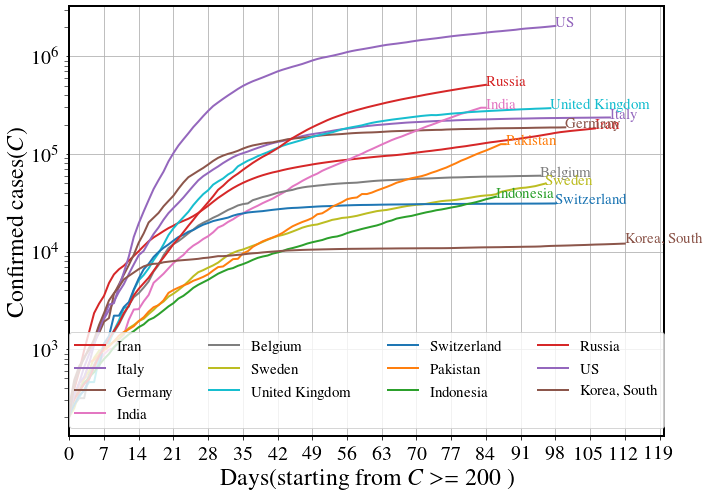

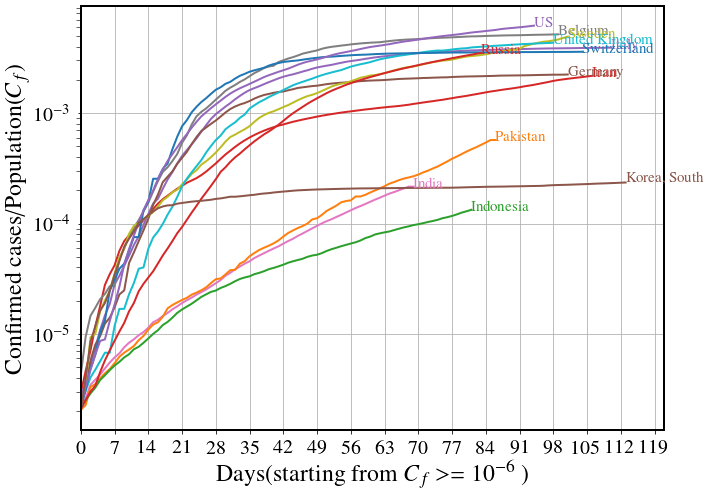

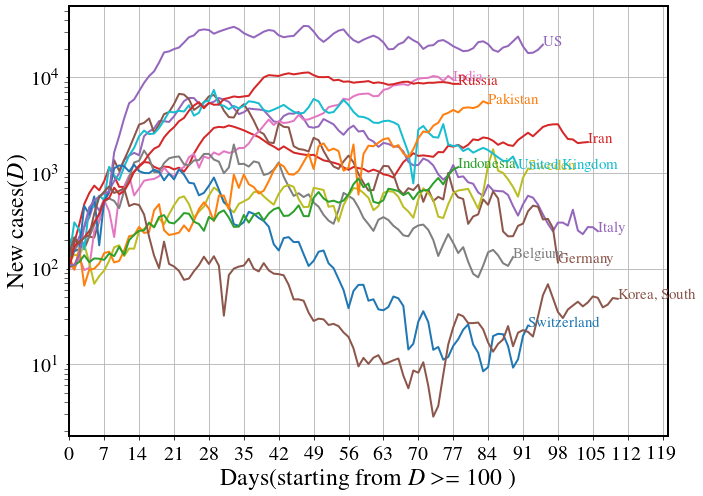

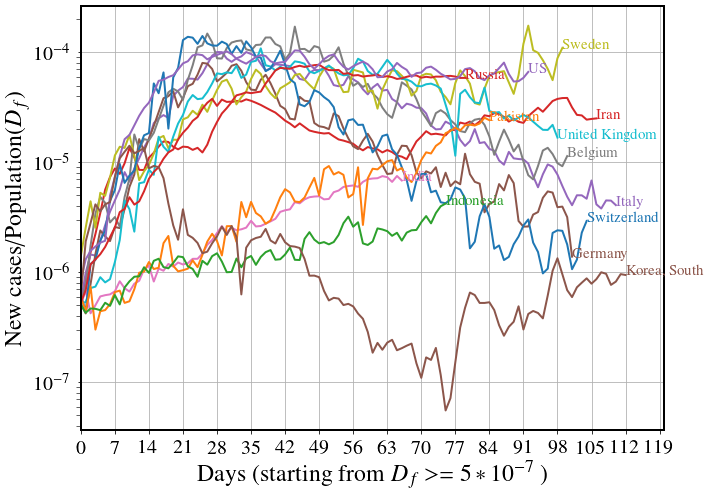

In [40]:
xdata=np.array([])
ydata=np.array([])
i=0

plt.figure(1,figsize=fsize)

plt.figure(2,figsize=fsize)
plt.figure(3,figsize=fsize)

plt.figure(4,figsize=fsize)

for country in Countries:    
    N=df_pop[df_pop["Country (or dependency)"]==country]["Population (2020)"].values[0]#Countries[country]
    plot_norm_country(country,N,i)
    
N=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0]#Countries[country]
plot_norm_country('US',N,i)
N=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0]#Countries[country]
plot_norm_country('Korea, South',N,i)
#N=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0]#Countries[country]
#plot_norm_country('China',N)
plt.figure(2)
plt.grid()
plt.ylabel('Confirmed cases/Population$(C_f)$')
plt.xlabel('Days(starting from $C_f >= 10^{-6}$ )')
plt.xticks(np.arange(0,end,7))
plt.xlim(0,end+1)
plt.tight_layout()

plt.savefig('Normalised Confirmed Cases')

plt.figure(1)
plt.grid()
plt.legend(fontsize=15,bbox_to_anchor=(0., 0.02, 1., .102), loc='lower left',ncol=4, mode="expand", borderaxespad=0.)

#fig=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
 #          ncol=3, mode="expand", borderaxespad=0.)
plt.ylabel('Confirmed cases$(C)$')
plt.xlabel('Days(starting from $C >= 200$ )')
plt.xticks(np.arange(0,end,7))
plt.xlim(0,end)

plt.tight_layout()
plt.savefig('Confirmed Cases')

plt.figure(4)
plt.grid()
plt.ylabel('New cases/Population$(D_f)$')
plt.xlabel('Days (starting from $D_f >= 5 * 10^{-7}$ )')
plt.xticks(np.arange(0,end,7))
plt.xlim(0,end)

plt.tight_layout()

plt.savefig('Normalised New Cases')

plt.figure(3)
plt.grid()
plt.ylabel('New cases$(D)$')
plt.xlabel('Days(starting from $D >= 100$ )')
plt.xticks(np.arange(0,end,7))
plt.tight_layout()
plt.xlim(0,end)

plt.savefig('New Cases')

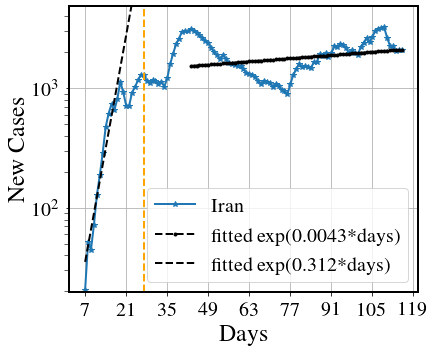

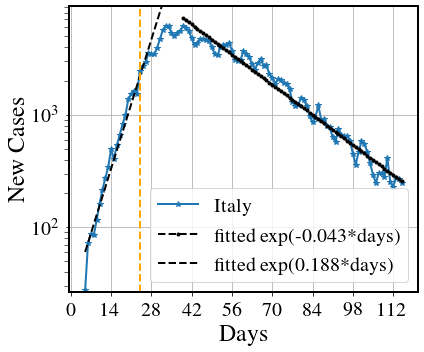

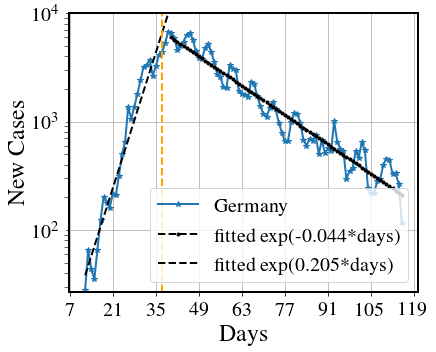

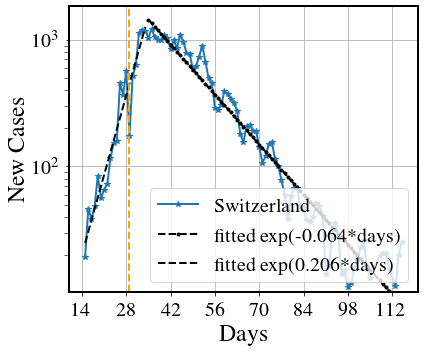

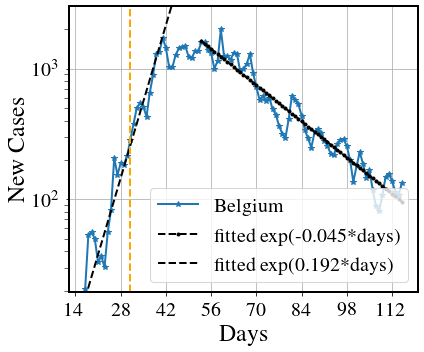

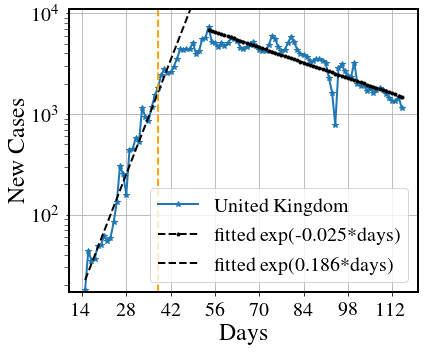

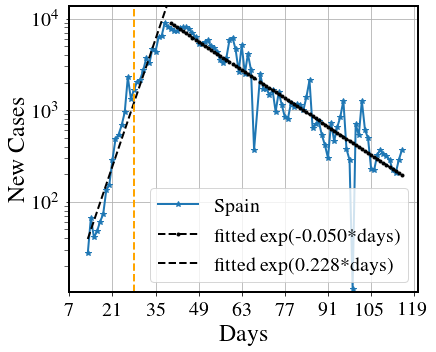

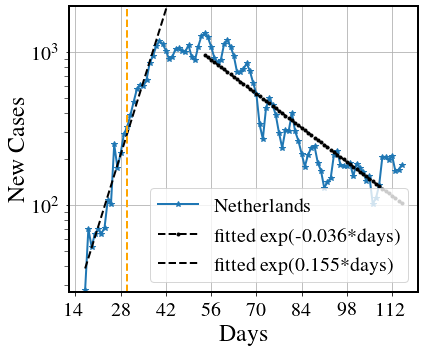

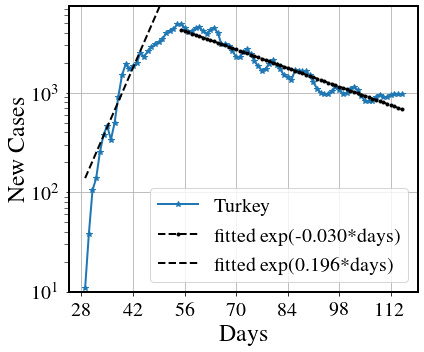

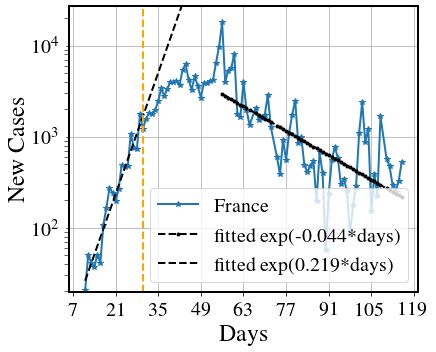

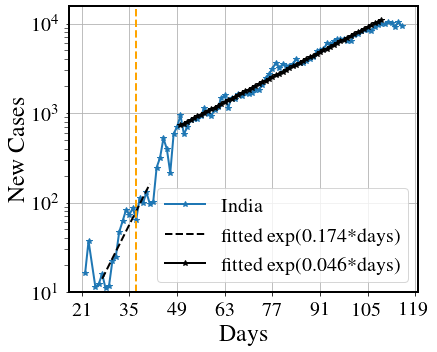

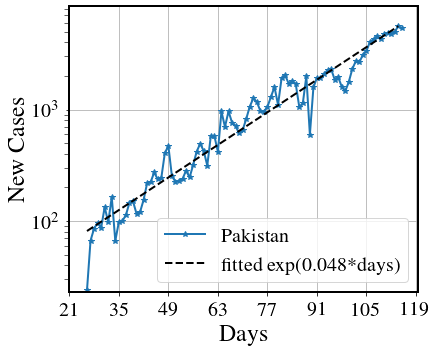

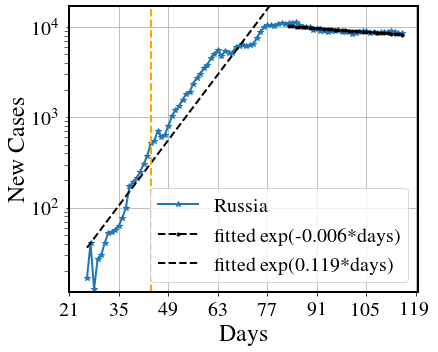

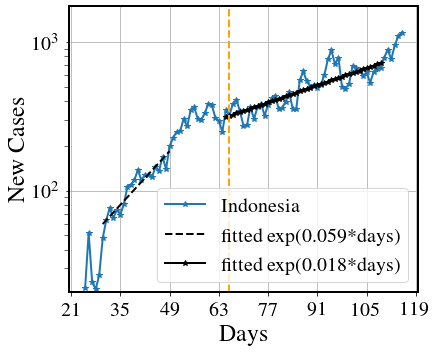

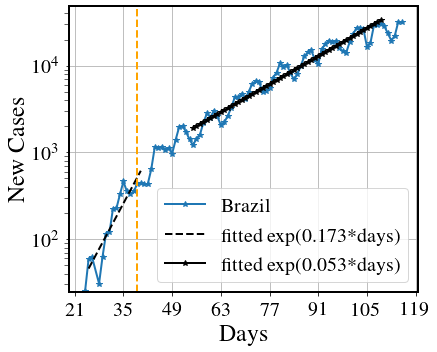

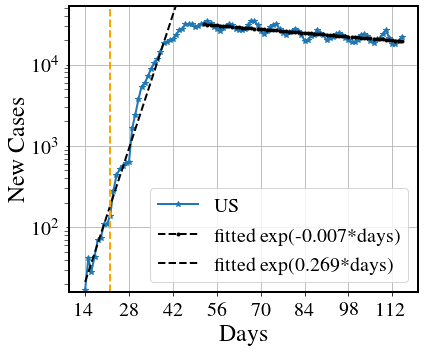

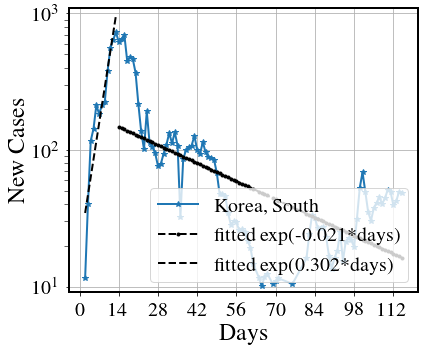

In [51]:
Countries2=['Iran','Italy', 'Germany' ,'Switzerland', 'Belgium','United Kingdom','Spain','Netherlands','Turkey','France','India','Pakistan','Russia','Indonesia','Brazil'] #'France'
Countries=Countries2+ ['United States','South Korea']
lockdate={'Italy': 24
        , 'Germany':37
       ,'Switzerland': 29
          ,'Iran': 27
        , 'US':22
        , 'United Kingdom':38
        , 'France':30
        , 'Spain':28
    , 'Russia':44
         , 'Belgium': 31
         , 'Netherlands':30
    }
def daily_cases(country,N):
    l=None
    xdata_c,ydata_c,Ti=get_data(country,l)
    ydata_c[:Ti]=0
    z=ydata_c
    t=1
    new_y_ma = (((z[t+1:-1]-z[t-1:-3])/2.0)+((z[t:-2]-z[t-1:-3]))+((z[t+2:]-z[t-1:-3])/3.0))/3.0
    idx1 = np.where(new_y_ma>1e+1)[0][0]
    xdata= np.arange(len(new_y_ma))
    new_y_ma=new_y_ma[idx1:]
    xdata= xdata[idx1:]
    pos_idx=np.where(new_y_ma>1e1)[0]
    new_y_ma=new_y_ma[pos_idx]
    xdata=xdata[pos_idx]
    D = pd.Series(new_y_ma, xdata)
    smoothed = D.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idmax=np.where(smoothed.values==max(smoothed))[0][0]
    postpeak=np.log(smoothed[idmax:])
    postpeak_x=xdata[idmax:]
    prepeak_x=xdata[:idmax]

    if len(postpeak)>5:
        
        z1, res, _, _, _ = np.polyfit(xdata[idmax:],np.log(new_y_ma[idmax:]),deg=1,full=True)
        z2, res, _, _, _ = np.polyfit(xdata[:idmax],np.log(new_y_ma[:idmax]),deg=1,full=True)
        if country =='US':
            idx_start=np.where(xdata==15)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+15],np.log(new_y_ma[idx_start:idx_start+15]),deg=1,full=True)
           # print(xdata[idx_start])
        if country =='United Kingdom':
            idx_start=np.where(xdata==15)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+30],np.log(new_y_ma[idx_start:idx_start+30]),deg=1,full=True)
        if country =='Italy':
            idx_start=np.where(xdata==5)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+25],np.log(new_y_ma[idx_start:idx_start+25]),deg=1,full=True)    
        
        if country =='France':
            idx_start=np.where(xdata==11)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+20],np.log(new_y_ma[idx_start:idx_start+20]),deg=1,full=True)
       
        if country =='Iran':
            idx_start=np.where(xdata==9)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+11],np.log(new_y_ma[idx_start:idx_start+11]),deg=1,full=True)
        if country =='Belgium':
            idx_start=np.where(xdata==21)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+20],np.log(new_y_ma[idx_start:idx_start+20]),deg=1,full=True)
        if country =='Netherlands':
            idx_start=np.where(xdata==17)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+24],np.log(new_y_ma[idx_start:idx_start+24]),deg=1,full=True)
        if country =='Turkey':
            idx_start=np.where(xdata==34)[0][0]
            z2, res, _, _, _ = np.polyfit(xdata[idx_start:idx_start+12],np.log(new_y_ma[idx_start:idx_start+12]),deg=1,full=True)
            
        
        plt.figure(figsize=(6,5))
        plt.plot(xdata,new_y_ma,'*-',label=country,color='C0')


        plt.plot(postpeak_x,np.exp(postpeak_x*z1[0]+z1[1]),'.--',color='black',label='fitted exp('+str(z1[0])[:6]+'*days)' )
        plt.plot(prepeak_x,np.exp(prepeak_x*z2[0]+z2[1]),'--',color='black',label='fitted exp('+str(z2[0])[:5]+'*days)' )

    else:
        z2, res, _, _, _ = np.polyfit(xdata,np.log(new_y_ma),deg=1,full=True)
        plt.figure(figsize=(6,5))
        plt.plot(xdata,new_y_ma,'*-',label=country,color='C0')
        
        if country =='Russia':
            idx_start=np.where(xdata==33)[0][0]
            dates=np.arange(idx_start,idx_start+20)
            z2, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)    
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z2[0]+z2[1]),'--',color='black',label='fitted exp('+str(z2[0])[:5]+'*days)' )
            
            idx_start=np.where(xdata==63)[0][0]
            dates=np.arange(idx_start,idx_start+19)
            z1, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z1[0]+z1[1]),'.-',color='black',label='fitted exp('+str(z1[0])[:5]+'*days)' )
        
        elif country == 'India':
            idx_start=np.where(xdata==27)[0][0]
            dates=np.arange(idx_start,idx_start+15)
            z2, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)  
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z2[0]+z2[1]),'--',color='black',label='fitted exp('+str(z2[0])[:5]+'*days)' )

            idx_start=np.where(xdata==50)[0][0]
            dates=np.arange(idx_start,idx_start+60)
            z1, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z1[0]+z1[1]),'*-',color='black',label='fitted exp('+str(z1[0])[:5]+'*days)' )
            plt.axvline(37,linestyle='dashed',color='orange')
        elif country == 'Indonesia':
            idx_start=np.where(xdata==30)[0][0]
            dates=np.arange(idx_start,idx_start+20)
            z2, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)  
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z2[0]+z2[1]),'--',color='black',label='fitted exp('+str(z2[0])[:5]+'*days)' )

            idx_start=np.where(xdata==65)[0][0]
            dates=np.arange(idx_start,idx_start+45)
            z1, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z1[0]+z1[1]),'*-',color='black',label='fitted exp('+str(z1[0])[:5]+'*days)' )
            plt.axvline(66,linestyle='dashed',color='orange')

        elif country == 'Brazil':
            idx_start=np.where(xdata==25)[0][0]
            dates=np.arange(idx_start,idx_start+15)
            z2, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)  
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z2[0]+z2[1]),'--',color='black',label='fitted exp('+str(z2[0])[:5]+'*days)' )

            idx_start=np.where(xdata==55)[0][0]
            dates=np.arange(idx_start,idx_start+55)
            z1, res, _, _, _ = np.polyfit(xdata[dates],np.log(new_y_ma[dates]),deg=1,full=True)
            plt.plot(prepeak_x[dates],np.exp(prepeak_x[dates]*z1[0]+z1[1]),'*-',color='black',label='fitted exp('+str(z1[0])[:5]+'*days)' )
            plt.axvline(39,linestyle='dashed',color='orange')
        
        else:
            plt.plot(prepeak_x,np.exp(prepeak_x*z2[0]+z2[1]),'--',color='black',label='fitted exp('+str(z2[0])[:5]+'*days)' )
    if country in lockdate.keys():
        plt.axvline(lockdate[country],linestyle='dashed',color='orange')
    plt.yscale('log')
    plt.ylim(min(new_y_ma)-1,max(new_y_ma)*1.5)
    plt.xlabel('Days')
    plt.ylabel('New Cases')
    plt.legend(fontsize=20,loc='lower right')
    plt.tight_layout()
    plt.xticks(np.arange(7*(xdata[0]//7),xdata[-1]+5,14))
    plt.grid()
    plt.savefig(country)
    return xdata[idmax],(z2[0])


idmaxs=[]
slopes=[]
for country in Countries2:    
    N=df_pop[df_pop["Country (or dependency)"]==country]["Population (2020)"].values[0]#Countries[country]
    idmax,slope=daily_cases(country,N)
    idmaxs.append(idmax)
    slopes.append(slope)

N=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0]#Countries[country]
idmax,slope=daily_cases('US',N)
idmaxs.append(idmax)
slopes.append(slope)
#print(slope)

N=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0]#Countries[country]
idmax,slope=daily_cases('Korea, South',N)
idmaxs.append(idmax)
slopes.append(slope)
#print(slope)


In [42]:
import datetime
t_values = [datetime.datetime.strptime(d, '%m/%d/%y').date().strftime('%c')[4:10] for d in df.columns[idmaxs]]

#convert to test data date:
t_values#[0].strftime('%b %d, %y%y')


['Mar 29',
 'Mar 25',
 'Mar 26',
 'Mar 21',
 'Apr  8',
 'Apr  9',
 'Mar 26',
 'Apr  9',
 'Apr 10',
 'Apr 11',
 'Jun  5',
 'Jun  9',
 'May  8',
 'Jun  9',
 'Jun  9',
 'Apr  7',
 'Feb 29']

In [ ]:
peak_df= pd.DataFrame()
peak_df['Countries']=Countries
peak_df['Peak Date']=t_values
peak_df['days from Feb 15']=idmaxs
peak_df['decay slope']=slopes
peak_df.set_index('Countries')

In [754]:
tedf=test_daily_df[test_daily_df['Entity']=='Turkey' ]
#print(tedf)
print(tedf[tedf['Date']=='Apr 10, 2020']['New tests per thousand'].values)

[0.366]


In [710]:
peak_df.to_csv('peak_newcases_dates_slopes')

In [711]:
test_daily_df=pd.read_csv('full-list-daily-covid-19-tests-per-thousand.csv')
test_daily_df.head()

,Entity,Code,Date,New tests per thousand
0,Argentina,ARG,"Apr 9, 2020",0.034
1,Argentina,ARG,"Apr 10, 2020",0.034
2,Argentina,ARG,"Apr 11, 2020",0.036
3,Argentina,ARG,"Apr 14, 2020",0.067
4,Argentina,ARG,"Apr 15, 2020",0.035


In [827]:
countries_test = { 'Italy':0.455,
 'Switzerland':0.718,
 'Belgium':0.472,
 'United Kingdom':0.158,
 'United States':0.461,
 'South Korea':0.288,'Turkey':0.366,'Germany':0.6}

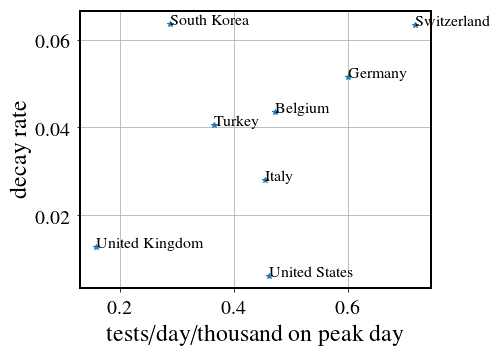

In [828]:
plt.figure(figsize=(7,5))
for country in countries_test.keys():
    x,y=countries_test[country],np.abs(peak_df[peak_df['Countries']==country]['decay slope'])
    plt.plot(x,y,'C0*')
    plt.text(x,y,country,fontsize=16)
plt.xlabel('tests/day/thousand on peak day')
plt.ylabel('decay rate')
plt.grid()
plt.tight_layout()
plt.savefig('tests_plot')

In [575]:

tests=np.zeros(len(Countries))
for i in range(len(Countries)):
   # print(country)
    country=Countries[i]
    date=t_values[i]+', 2020'
    tedf=test_daily_df[test_daily_df['Entity']==country ]
  #  print(date,country,tedf)
    print(tedf[tedf['Date']==date]['New tests per thousand'].values)#and test_daily_df['Date']==date

[]
[0.455]
[]
[0.718]
[]
[]
[]
[]
[]
[0.288]


In [573]:
d=test_daily_df['Date'][1]
datetime.datetime.strptime(d, '%d').date()

ValueError: time data 'Apr 10, 2020' does not match format '%d'

In [542]:
tests

array([0.288])

/home/srashti/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


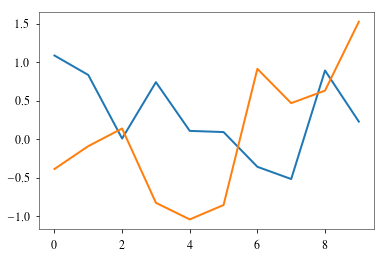

<Figure size 216x144 with 0 Axes>

In [371]:
import pylab
fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
figlegend.legend(lines, ('one', 'two'), 'center')
fig.show()
figlegend.show()
figlegend.savefig('legend.png')

Austria : Estimated \lambda = [-0.57325239  0.30643518 -0.1427066 ]


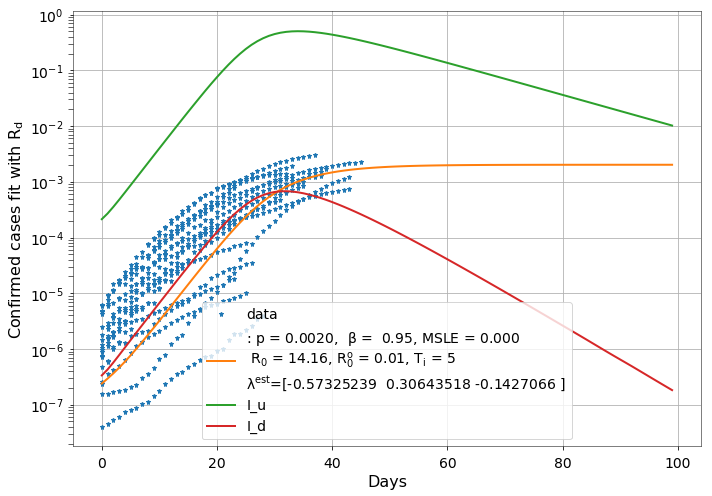

In [84]:
bounds1=((0.00001,.95),(0.,2.5),(1,50)) # ((pmin,pmax),(beta_min, beta_max))


Tl = 5
Tr = 15
Td = 7
sol1=fit_seiirr(xdata,ydata,bounds=bounds1)

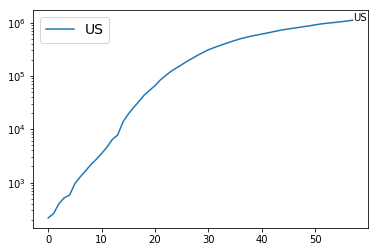

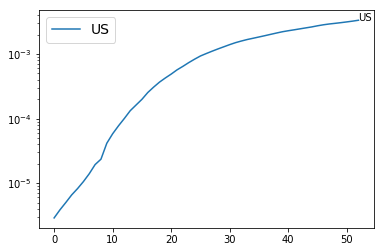

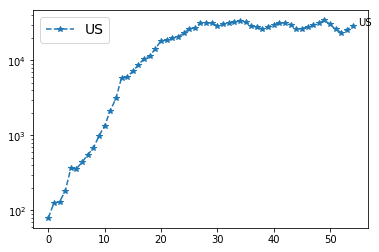

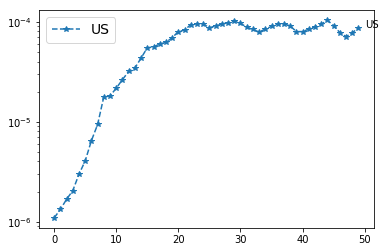

In [168]:
N=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0]#Countries[country]
plot_norm_country('US',N,i)

In [1253]:
tests= pd.read_csv('number-of-covid-19-tests-per-confirmed-case-bar-chart.csv')
tests['Date']=pd.to_datetime(tests['Date'].values,infer_datetime_format=True)
Countries=[ 'India','Israel','Denmark','Switzerland','Turkey','United States','United Kingdom','Pakistan','Indonesia','South Korea']
tests.head()

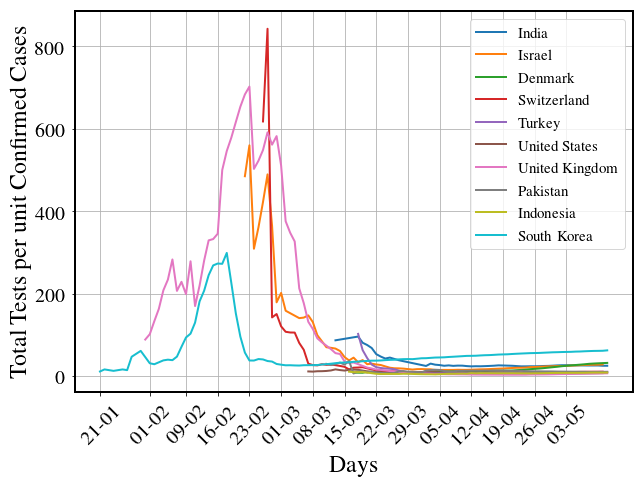

In [1345]:
plt.figure(figsize=(10,7))
for country in Countries:
    df2=tests[tests['Entity']==country]
    #dt=[ datetime.datetime.strptime(x, '%d%m').date() for x in df2['Date']]
    plt.plot(df2['Date'].values,df2['Number of tests per confirmed case'].values,label=country)
    #sns.lineplot(dt,df2['Number of tests per confirmed case'].values,label=country)

df2=tests[tests['Entity']=='South Korea']
plt.xticks(df2['Date'].iloc[np.arange(0,100,7)],rotation=45)
ax = plt.gca()
ax.set_xticklabels([x.strftime('%d-%m') for x in df2['Date'].iloc[np.arange(0,100,7)]] )
plt.legend()
plt.grid()
#plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('Total Tests per  unit Confirmed Cases')
plt.savefig('TD')

In [1229]:
d1=tests[tests['Date']=='2020-04-08']
tests_per_confirmed=[d1[d1['Entity']== country]['Number of tests per confirmed case'].values[0] for country in Countries]
tests_per_confirmed

[46.803000000000004,
 24.628,
 14.812999999999999,
 11.345999999999998,
 8.283,
 7.263999999999999,
 5.6129999999999995,
 4.213,
 11.026,
 5.322]

In [1230]:
df1=pd.DataFrame()
df1['tests_per_confirmed']=tests_per_confirmed
df1['Country']=Countries
df1.sort_values('tests_per_confirmed',ascending=False)

,tests_per_confirmed,Country
0,46.803,South Korea
1,24.628,India
2,14.813,Israel
3,11.346,Denmark
8,11.026,Pakistan
4,8.283,Switzerland
5,7.264,Turkey
6,5.613,United States
9,5.322,Indonesia
7,4.213,United Kingdom


In [1231]:
plt.figure(figsize=(10,7))
sns.barplot(x=df1['tests_per_confirmed'].values, y =df1['Country'].values)
plt.title('Total Tests per Confirmed Case -April 8',fontsize=20)
plt.xlim(0,70)
plt.tight_layout()
plt.savefig('apr8')

In [56]:
tests= pd.read_csv('covid-daily-tests-cases-deaths-rolling-average.csv')
tests['Date']=pd.to_datetime(tests['Date'].values,infer_datetime_format=True)
Countries=[ 'India','Belgium','Russia','Switzerland','Italy','United States','United Kingdom','Pakistan','Indonesia','South Korea']
tests['T/D']=tests['Daily tests']/tests['Daily new confirmed cases']
tests.head()


,Entity,Code,Date,Daily tests,Daily new confirmed cases,Daily new confirmed deaths,T/D
0,Afghanistan,AFG,2019-12-31,NaN,0.0,0.0,NaN
1,Afghanistan,AFG,2020-01-01,NaN,0.0,0.0,NaN
2,Afghanistan,AFG,2020-01-02,NaN,0.0,0.0,NaN
3,Afghanistan,AFG,2020-01-03,NaN,0.0,0.0,NaN
4,Afghanistan,AFG,2020-01-04,NaN,0.0,0.0,NaN


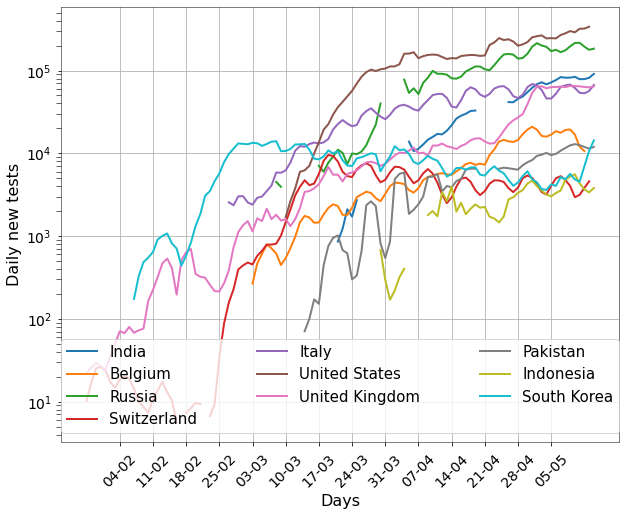

In [31]:
plt.figure(figsize=(10,8))
for country in Countries:
    df2=tests[tests['Entity']==country]
    #dt=[ datetime.datetime.strptime(x, '%d%m').date() for x in df2['Date']]
    plt.plot(df2['Date'].values,df2['Daily tests'].values,label=country)
    #sns.lineplot(dt,df2['Number of tests per confirmed case'].values,label=country)

df2=tests[tests['Entity']=='South Korea']
plt.xticks(df2['Date'].iloc[np.arange(7*5,130,7)],rotation=45)
ax = plt.gca()
ax.set_xticklabels([x.strftime('%d-%m') for x in df2['Date'].iloc[np.arange(7*5,130,7)]] )
plt.legend(fontsize=15,bbox_to_anchor=(0., 0.02, 1., .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
plt.grid()
#plt.xlim(df2['Date'].iloc[0],df2['Date'].iloc[-1])
plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('Daily new tests')
plt.savefig('T-rolling_actual-log')

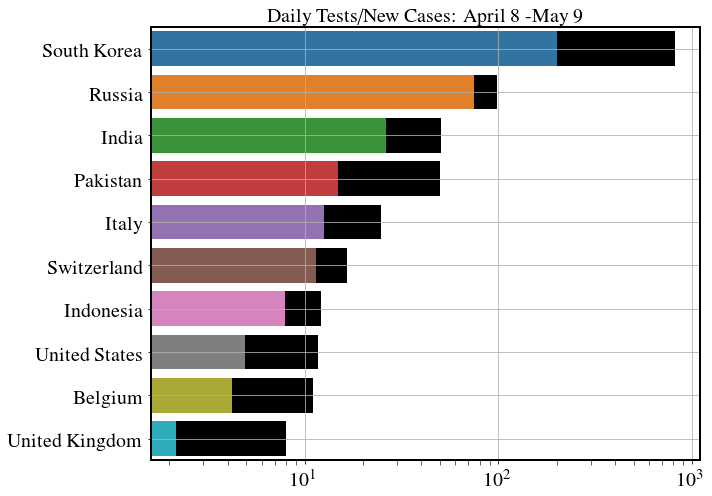

In [1462]:
d1=tests[tests['Date']=='2020-05-08']
tests_per_confirmed=[d1[d1['Entity']== country]['T/D'].values[0] for country in Countries]
df1=pd.DataFrame()
df1['tests_per_confirmed']=tests_per_confirmed
df1['Country']=Countries
df1=df1.sort_values('tests_per_confirmed',ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(x=df1['tests_per_confirmed'].values, y =df1['Country'].values,facecolor=(0, 0, 0, 1))

d1=tests[tests['Date']=='2020-04-09']
tests_per_confirmed=[d1[d1['Entity']== country]['T/D'].values[0] for country in Countries]
df1=pd.DataFrame()
df1['tests_per_confirmed']=tests_per_confirmed
df1['Country']=Countries
df1=df1.sort_values('tests_per_confirmed',ascending=False)
sns.barplot(x=df1['tests_per_confirmed'].values, y =df1['Country'].values)


plt.title('Daily Tests/New Cases: April 8 -May 9',fontsize=20)
#plt.xlim(0,510)
plt.xscale('log')
plt.tight_layout()
plt.grid()
plt.savefig('bar_TD_log') #7


In [1377]:
df1=pd.DataFrame()
df1['tests_per_confirmed']=tests_per_confirmed
df1['Country']=Countries
df1=df1.sort_values('tests_per_confirmed',ascending=False)

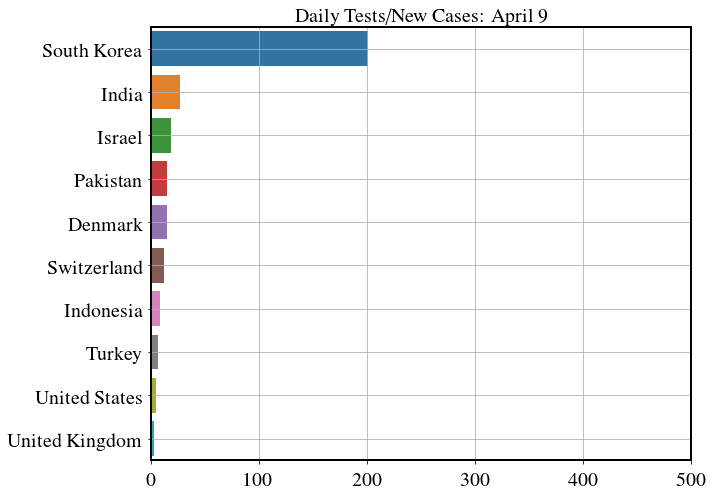

In [44]:
tests= pd.read_csv('daily-tests-per-thousand-people-smoothed-7-day.csv')
tests['Date']=pd.to_datetime(tests['Date'].values,infer_datetime_format=True)
Countries=[ 'India','Belgium','Russia','Switzerland','Italy','United States','United Kingdom','Pakistan','Indonesia','South Korea']
#tests['T/D']=tests['Daily tests']/tests['Daily new confirmed cases']
tests.head()


,Entity,Code,Date,Daily tests per thousand people (7-day smoothed) (tests per thousand)
0,Argentina,ARG,2020-04-15,0.035
1,Argentina,ARG,2020-04-16,0.037
2,Argentina,ARG,2020-04-17,0.039
3,Argentina,ARG,2020-04-18,0.041
4,Argentina,ARG,2020-04-19,0.044


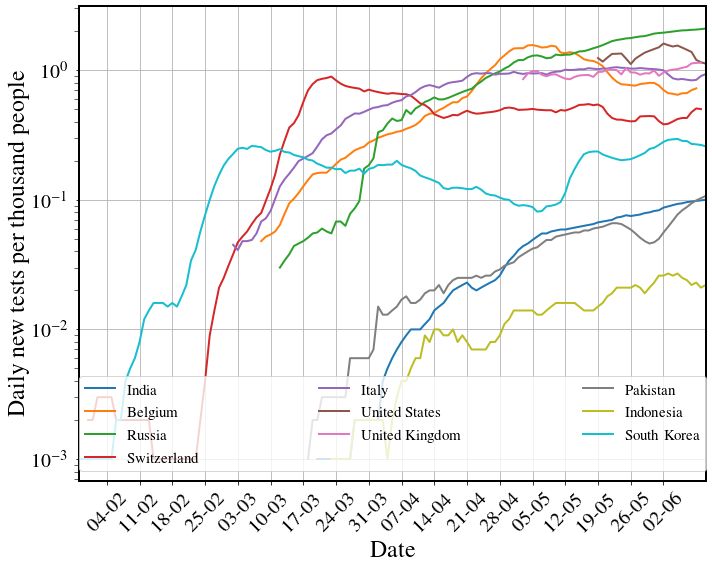

In [47]:
plt.figure(figsize=(10,8))
for country in Countries:
    df2=tests[tests['Entity']==country]
    #dt=[ datetime.datetime.strptime(x, '%d%m').date() for x in df2['Date']]
    plt.plot(df2['Date'].values,df2['Daily tests per thousand people (7-day smoothed) (tests per thousand)'].values,label=country)
    #sns.lineplot(dt,df2['Number of tests per confirmed case'].values,label=country)

df2=tests[tests['Entity']=='South Korea']
plt.xticks(df2['Date'].iloc[np.arange(7*1,129,7)],rotation=45)
ax = plt.gca()
ax.set_xticklabels([x.strftime('%d-%m') for x in df2['Date'].iloc[np.arange(7*1,129,7)]] )
plt.legend(fontsize=15,bbox_to_anchor=(0., 0.02, 1., .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
plt.grid()
plt.xlim(df2['Date'].iloc[1],df2['Date'].iloc[-1])
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Daily new tests per thousand people')
plt.tight_layout()
plt.savefig('Tperthousand-rolling_7days-log')